In [ ]:
!pip install tensorflow

In [ ]:
import pandas as pd
import numpy as np
from tabulate import tabulate

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTENC
from imblearn.over_sampling import ADASYN


In [ ]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import roc_auc_score
from imblearn.over_sampling import SMOTENC
import tensorflow as tf
from tensorflow.keras import layers, models, Input
import tensorflow.keras.backend as K # Import keras backend

In [ ]:
def focal_loss(gamma=2., alpha=0.40):
    def focal_loss_fixed(y_true, y_pred):
        # K = keras.backend  # Define K here using keras.backend - No need for this line now
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1)) - \
               K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0))
    return focal_loss_fixed

In [ ]:
# === Load and preprocess data ==
df = pd.read_csv("carclaims.csv")
df["FraudFound"] = df["FraudFound"].map({"Yes": 1, "No": 0})
df.drop(columns=["PolicyNumber", "RepNumber", "Year", "Age"], inplace=True)

X = df.drop(columns=["FraudFound"])
y = df["FraudFound"]

In [ ]:
# Identify column types
numeric_cols = X.select_dtypes(include=["int64", "float64"]).columns.tolist()
categorical_cols = X.select_dtypes(include=["object"]).columns.tolist()

# Define encoding strategies
one_hot_cols = [
    "Month", "MonthClaimed", "DayOfWeek", "DayOfWeekClaimed", "Sex", "MaritalStatus",
    "AccidentArea", "Fault", "PolicyType", "VehicleCategory", "PoliceReportFiled",
    "WitnessPresent", "AgentType", "BasePolicy", "WeekOfMonth", "WeekOfMonthClaimed","Make"
]

ordinal_cols = [
    "VehiclePrice", "Days:Policy-Accident", "Days:Policy-Claim", "PastNumberOfClaims",
    "AgeOfVehicle", "AgeOfPolicyHolder", "NumberOfSuppliments", "AddressChange-Claim",
    "NumberOfCars", "Deductible", "DriverRating"
]

embedding_col = ["Make"]

In [ ]:
print("ordinal_cols")
print(ordinal_cols, len(ordinal_cols))
print("one_hot_cols")
print(one_hot_cols,len(one_hot_cols))
print("numeric_cols")
print(numeric_cols,len(numeric_cols))

ordinal_cols
['VehiclePrice', 'Days:Policy-Accident', 'Days:Policy-Claim', 'PastNumberOfClaims', 'AgeOfVehicle', 'AgeOfPolicyHolder', 'NumberOfSuppliments', 'AddressChange-Claim', 'NumberOfCars', 'Deductible', 'DriverRating'] 11
one_hot_cols
['Month', 'MonthClaimed', 'DayOfWeek', 'DayOfWeekClaimed', 'Sex', 'MaritalStatus', 'AccidentArea', 'Fault', 'PolicyType', 'VehicleCategory', 'PoliceReportFiled', 'WitnessPresent', 'AgentType', 'BasePolicy', 'WeekOfMonth', 'WeekOfMonthClaimed', 'Make'] 17
numeric_cols
['WeekOfMonth', 'WeekOfMonthClaimed', 'Deductible', 'DriverRating'] 4


## Pipelines for pre-processing

In [ ]:
categorical_cols_cleaned = list(set(one_hot_cols + ordinal_cols + embedding_col))
remaining_cols = [col for col in X.columns if col not in categorical_cols_cleaned]
final_numeric_cols = [col for col in remaining_cols if col in numeric_cols]


# ---------------------------
# 2. Preprocessing Pipelines
# ---------------------------

# numeric_transformer = Pipeline([
#     ("imputer", SimpleImputer(strategy="median")),
#     ("scaler", StandardScaler())
# ])

one_hot_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

ordinal_transformer = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("ordinal", OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1))
])

preprocessor = ColumnTransformer([
    ("onehot", one_hot_transformer, one_hot_cols),
    ("ordinal", ordinal_transformer, ordinal_cols)
])

## Train/Test Split

In [ ]:

# ---------------------------
# 3. Train/Test Split & Oversampling
# ---------------------------

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

X_train_proc = preprocessor.fit_transform(X_train)
X_test_proc = preprocessor.transform(X_test)

## Oversampling Train daata through ADASYN

In [ ]:
# Apply ADASYN to numeric+encoded inputs only
print("Class distribution before ADASYN:")
print(y_train.value_counts(normalize=True))
adasyn = ADASYN(random_state=42, sampling_strategy=0.8)
X_train_res, y_train_res = adasyn.fit_resample(X_train_proc, y_train)

# Calculate the oversampling ratio
oversampling_ratio = len(y_train_res) / len(y_train)


print("Class distribution after ADASYN:")
print(pd.Series(y_train_res).value_counts(normalize=True))

Class distribution before ADASYN:
FraudFound
0    0.940175
1    0.059825
Name: proportion, dtype: float64
Class distribution after ADASYN:
FraudFound
0    0.553948
1    0.446052
Name: proportion, dtype: float64


## Optimal Feature Selection using mutual-info & nn

In [ ]:
# ---------------------------
# 4. Optimal Feature Selection
# ---------------------------

mi_scores = mutual_info_classif(X_train_res, y_train_res, random_state=42)
sorted_indices = np.argsort(mi_scores)[::-1]

In [ ]:

# Try different top-k features
best_auc = 0
best_k = 0
best_features = None
for k in range(20, X_train_res.shape[1], 10):
    top_k_indices = sorted_indices[:k]
    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    aucs = []
    for train_idx, val_idx in skf.split(X_train_res[:, top_k_indices], y_train_res):
        model = models.Sequential([
            layers.Dense(64, activation="relu", input_shape=(k,)),
            layers.Dense(32, activation="relu"),
            layers.Dense(1, activation="sigmoid")
        ])
        model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["AUC"])
        model.fit(X_train_res[train_idx][:, top_k_indices], y_train_res[train_idx], epochs=5, batch_size=64, verbose=0)
        auc = model.evaluate(X_train_res[val_idx][:, top_k_indices], y_train_res[val_idx], verbose=0)[1]
        aucs.append(auc)
    avg_auc = np.mean(aucs)
    if avg_auc > best_auc:
        best_auc = avg_auc
        best_k = k
        best_features = top_k_indices

X_train_final = X_train_res[:, best_features]
X_test_final = X_test_proc[:, best_features]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

In [ ]:
# Get feature names from preprocessor
feature_names = preprocessor.get_feature_names_out()

# Get the top 15 indices from the sorted list
top_15_indices = sorted_indices[:15]

# Fetch the feature names
top_15_features = [feature_names[i] for i in top_15_indices]

# Print them
print("Top 15 features based on importance:")
for rank, feat in enumerate(top_15_features, 1):
    print(f"{rank}. {feat}")

Top 15 features based on importance:
1. ordinal__DriverRating
2. ordinal__AgeOfVehicle
3. ordinal__AgeOfPolicyHolder
4. ordinal__NumberOfSuppliments
5. ordinal__PastNumberOfClaims
6. ordinal__VehiclePrice
7. onehot__Make_Pontiac
8. onehot__PolicyType_Sedan - Liability
9. onehot__WeekOfMonth_2
10. onehot__DayOfWeekClaimed_Monday
11. onehot__DayOfWeekClaimed_Tuesday
12. onehot__BasePolicy_Liability
13. onehot__WeekOfMonth_3
14. onehot__Make_Toyota
15. onehot__WeekOfMonthClaimed_4


## DNN Model

In [ ]:

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

# Define focal loss
def focal_loss(gamma=2., alpha=0.41):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        return -tf.keras.backend.mean(alpha * tf.keras.backend.pow(1. - pt_1, gamma) * tf.keras.backend.log(pt_1)) - \
               tf.keras.backend.mean((1 - alpha) * tf.keras.backend.pow(pt_0, gamma) * tf.keras.backend.log(1. - pt_0))
    return focal_loss_fixed

# Build improved DNN model
def build_improved_model(input_dim, learning_rate=1e-3):
    model = Sequential()
    model.add(Dense(128, input_shape=(input_dim,)))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Dense(64))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Dense(32))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.2))

    model.add(Dense(16))
    model.add(BatchNormalization())
    model.add(LeakyReLU())
    model.add(Dropout(0.15))

    model.add(Dense(1, activation='sigmoid'))

    model.compile(
        optimizer=Adam(learning_rate=learning_rate),
        loss=focal_loss(gamma=2., alpha=0.35),
        metrics=["accuracy", tf.keras.metrics.AUC(name="auc")]
    )
    return model


In [ ]:


### USING TOP K FEATURES###

X_train, X_val, y_train, y_val = train_test_split(
    X_train_final, y_train_res, test_size=0.2, stratify=y_train_res, random_state=42 # Use X_train_res instead of X_train_proc and y_train_res instead of y_train
)

In [ ]:
model1 = build_improved_model(input_dim=X_train.shape[1])
model1.summary()
history1 =model1.fit(X_train, y_train, epochs=40, batch_size=256, validation_data=(X_val, y_val),
          callbacks=[EarlyStopping(patience=6, restore_best_weights=True)])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_30"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_90 (Dense)                │ (None, 128)            │        11,648 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_91 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_92 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_93 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 16)             │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_94 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,489 (91.75 KB)

 Trainable params: 23,009 (89.88 KB)

 Non-trainable params: 480 (1.88 KB)

Epoch 1/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 7s 18ms/step - accuracy: 0.5733 - auc: 0.6113 - loss: 0.1132 - val_accuracy: 0.6404 - val_auc: 0.8105 - val_loss: 0.0624
Epoch 2/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.6648 - auc: 0.7511 - loss: 0.0740 - val_accuracy: 0.7323 - val_auc: 0.8477 - val_loss: 0.0562
Epoch 3/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.6928 - auc: 0.7938 - loss: 0.0659 - val_accuracy: 0.7237 - val_auc: 0.8653 - val_loss: 0.0540
Epoch 4/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.7080 - auc: 0.8146 - loss: 0.0615 - val_accuracy: 0.7629 - val_auc: 0.8726 - val_loss: 0.0521
Epoch 5/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.7240 - auc: 0.8293 - loss: 0.0594 - val_accuracy: 0.7884 - val_auc: 0.8843 - val_loss: 0.0507
Epoch 6/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7396 - auc: 0.8452 - loss: 0.0567 - val_accuracy: 0.7947 - val_auc: 0.8937 - val_loss: 0.0490
Epoch 7/40
66/66 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/

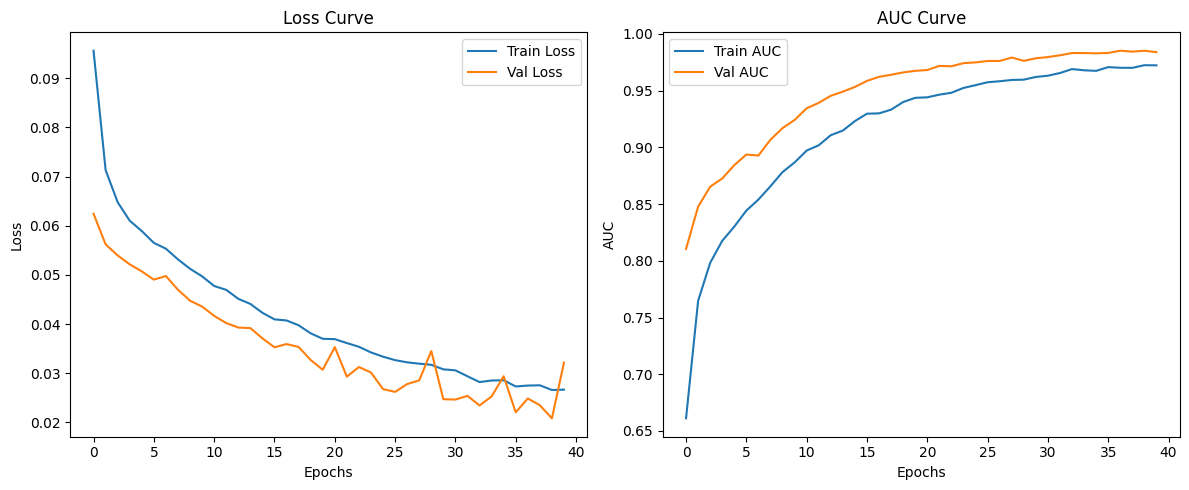

In [ ]:
# Plot training and validation loss and AUC
history_dict = history1.history

plt.figure(figsize=(12, 5))

# Loss Curve
plt.subplot(1, 2, 1)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# AUC Curve
plt.subplot(1, 2, 2)
plt.plot(history_dict['auc'], label='Train AUC')
plt.plot(history_dict['val_auc'], label='Val AUC')
plt.title('AUC Curve')
plt.xlabel('Epochs')
plt.ylabel('AUC')
plt.legend()

plt.tight_layout()
plt.show()


97/97 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
Optimal Threshold based on F1 Score: 0.3973

Classification Report:

              precision    recall  f1-score   support

           0       0.96      0.88      0.92      2899
           1       0.19      0.44      0.26       185

    accuracy                           0.85      3084
   macro avg       0.58      0.66      0.59      3084
weighted avg       0.91      0.85      0.88      3084



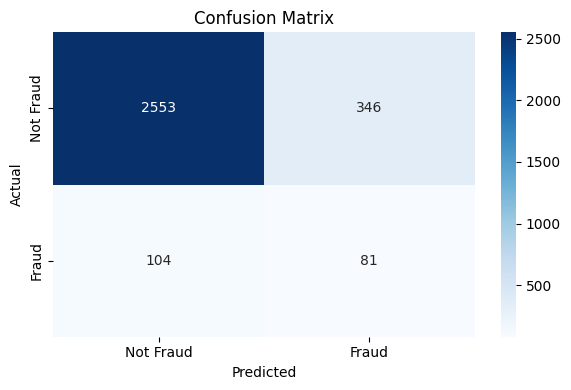

In [ ]:
#from sklearn.metrics import classification_report, confusion_matrix, precision_recall_curve
#import matplotlib.pyplot as plt
#import seaborn as sns
#import numpy as np

# 1. Predict probabilities
# X_test_final = preprocessor.transform(X_test) # This is what you originally had
X_test_final = X_test_proc[:, best_features] # Applying feature selection to X_test_proc using the best features as done for X_train_final
# Now use the transformed data for prediction
y_pred_probs = model1.predict(X_test_final).ravel()


# 2. Optional: Tune threshold for better recall (use only if needed)
prec, rec, thresholds = precision_recall_curve(y_test, y_pred_probs)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
best_thresh = thresholds[np.argmax(f1_scores)]

# Use beta > 1 to emphasize recall
beta = 1.5
f1_weighted = (1 + beta**2) * (prec * rec) / ((beta**2 * prec) + rec + 1e-6)

# Find threshold that maximizes the weighted F1 score
best_thresh = thresholds[np.argmax(f1_weighted)]

print(f"Optimal Threshold based on F1 Score: {best_thresh:.4f}")

# 3. Apply optimal threshold
y_pred_labels = (y_pred_probs >= best_thresh).astype(int)

# 4. Print classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred_labels))

# 5. Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_labels)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

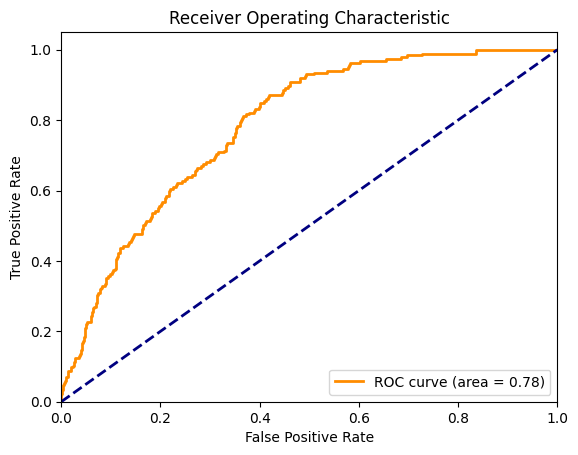

In [ ]:
# prompt: plot ROC for this

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_probs are already defined from previous code

# Compute ROC curve and ROC area
fpr, tpr, _ = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


## XGBoost Model

In [ ]:
from sklearn.metrics import precision_recall_curve, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
import numpy as np

# Step 2: Train an XGBoost model (using same train/val split as DNN)
from xgboost import XGBClassifier

# Count of class labels to compute scale_pos_weight
neg, pos = np.bincount(y_train)
scale = neg / pos

xgb_model = XGBClassifier(
    n_estimators=500,              # More trees
    learning_rate=0.05,            # Slower learning
    max_depth=6,                   # Prevents overfitting
    min_child_weight=5,            # Minimum instances in a leaf
    gamma=0.2,                     # Minimum loss reduction to make a split
    subsample=0.8,                 # Row subsample ratio
    colsample_bytree=0.8,          # Feature subsample ratio
    reg_alpha=0.5,                 # L1 regularization
    reg_lambda=1.0,                # L2 regularization
    scale_pos_weight=scale,        # Handles imbalance (major key!)
    objective='binary:logistic',
    eval_metric='auc',             # Better for fraud detection than logloss
    use_label_encoder=False,
    random_state=42,
    verbosity=1
)

xgb_model.fit(X_train, y_train,
              eval_set=[(X_val, y_val)],
              verbose=True)

[0]	validation_0-auc:0.85221
[1]	validation_0-auc:0.86440
[2]	validation_0-auc:0.89094
[3]	validation_0-auc:0.89775
[4]	validation_0-auc:0.92274
[5]	validation_0-auc:0.94606


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [13:52:39] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[6]	validation_0-auc:0.95490
[7]	validation_0-auc:0.95289
[8]	validation_0-auc:0.95744
[9]	validation_0-auc:0.96473
[10]	validation_0-auc:0.96982
[11]	validation_0-auc:0.97208
[12]	validation_0-auc:0.97380
[13]	validation_0-auc:0.97551
[14]	validation_0-auc:0.97714
[15]	validation_0-auc:0.97865
[16]	validation_0-auc:0.97969
[17]	validation_0-auc:0.98099
[18]	validation_0-auc:0.98161
[19]	validation_0-auc:0.98161
[20]	validation_0-auc:0.98218
[21]	validation_0-auc:0.98254
[22]	validation_0-auc:0.98251
[23]	validation_0-auc:0.98256
[24]	validation_0-auc:0.98279
[25]	validation_0-auc:0.98312
[26]	validation_0-auc:0.98342
[27]	validation_0-auc:0.98376
[28]	validation_0-auc:0.98402
[29]	validation_0-auc:0.98428
[30]	validation_0-auc:0.98425
[31]	validation_0-auc:0.98438
[32]	validation_0-auc:0.98462
[33]	validation_0-auc:0.98461
[34]	validation_0-auc:0.98464
[35]	validation_0-auc:0.98476
[36]	validation_0-auc:0.98492
[37]	validation_0-auc:0.98507
[38]	validation_0-auc:0.98514
[39]	validatio

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=0.2, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=500, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

              precision    recall  f1-score   support

           0       0.94      0.99      0.97      2899
           1       0.29      0.04      0.07       185

    accuracy                           0.94      3084
   macro avg       0.62      0.52      0.52      3084
weighted avg       0.90      0.94      0.91      3084



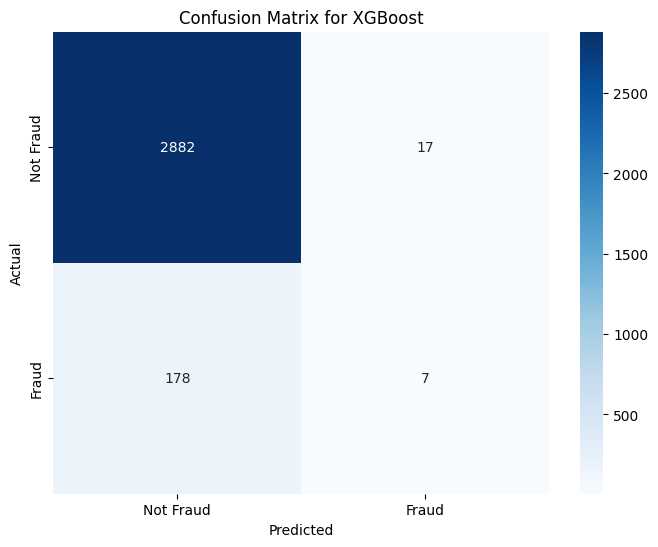

In [ ]:

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_xgb = xgb_model.predict(X_test_final)

# Classification Report
print(classification_report(y_test, y_pred_xgb))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_xgb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"], yticklabels=["Not Fraud", "Fraud"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for XGBoost")
plt.show()


## Ensemble - Soft voting - DNN & XGboost

97/97 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

 Optimal Threshold (F1): 0.3072

 Classification Report (Soft Voting):

              precision    recall  f1-score   support

           0       0.96      0.91      0.93      2899
           1       0.22      0.40      0.28       185

    accuracy                           0.88      3084
   macro avg       0.59      0.65      0.61      3084
weighted avg       0.91      0.88      0.89      3084



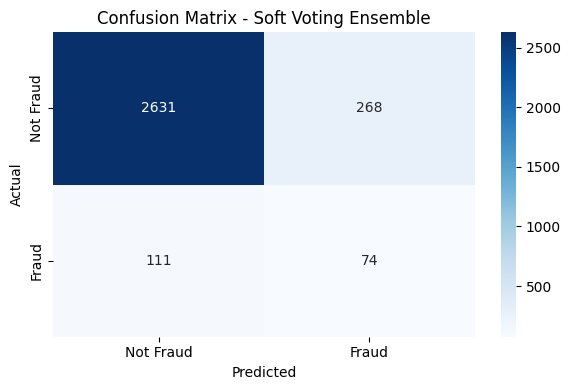

In [ ]:
# Step 3: Predict probabilities from both models
# Apply feature selection and preprocessing to X_test before DNN prediction
X_test_for_dnn = preprocessor.transform(X_test)[:, best_features]
dnn_probs = model1.predict(X_test_for_dnn).ravel()  # Use the preprocessed X_test_for_dnn

# Apply feature selection to X_test before XGBoost prediction (if necessary)
X_test_for_xgb = preprocessor.transform(X_test)[:, best_features]
xgb_probs = xgb_model.predict_proba(X_test_for_xgb)[:, 1]  # Use preprocessed X_test_for_xgb

# Step 4: Average probabilities (soft voting)
ensemble_probs = 0.5 * dnn_probs + 0.5 * xgb_probs  # or reverse

# Step 5: Tune threshold for optimal F1 score
prec, rec, thresholds = precision_recall_curve(y_test, ensemble_probs)
f1_scores = 2 * (prec * rec) / (prec + rec + 1e-6)
best_thresh = thresholds[np.argmax(f1_scores)]
print(f"\n Optimal Threshold (F1): {best_thresh:.4f}")

# Step 6: Apply threshold to generate final predictions
y_pred_ensemble = (ensemble_probs >= best_thresh).astype(int)

# Step 7: Print classification report
print("\n Classification Report (Soft Voting):\n")
print(classification_report(y_test, y_pred_ensemble))

# Step 8: Confusion matrix visualization
conf_matrix = confusion_matrix(y_test, y_pred_ensemble)
plt.figure(figsize=(6, 4))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Not Fraud", "Fraud"],
            yticklabels=["Not Fraud", "Fraud"])
plt.title("Confusion Matrix - Soft Voting Ensemble")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

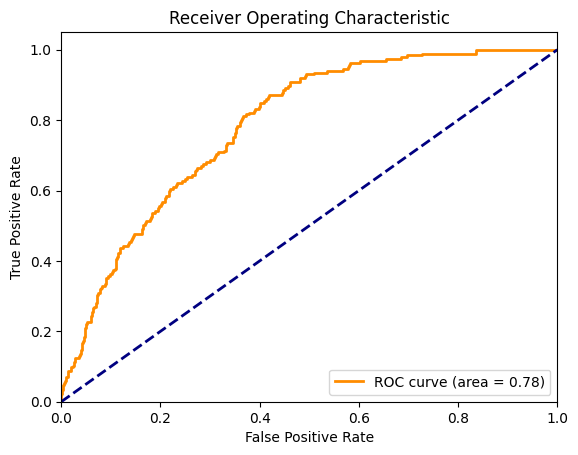

In [ ]:
# prompt: plot ROC for this one

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Assuming y_test and y_pred_probs are defined from your previous code
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


In [ ]:
# prompt: Can you implement expalianability Like SHAP , LIME do the best you can by reading all the cells from top
import shap

# Assuming X_test_final and model1 are defined from the previous code

# Explain predictions of the first 10 instances
explainer = shap.KernelExplainer(model1.predict, X_train[:100]) # Use a subset of training data as background data
shap_values = explainer.shap_values(X_test_final[:10])



# Visualize the first prediction's explanation
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0][0,:], X_test_final[0,:], feature_names=preprocessor.get_feature_names_out()[best_features]) # Pass feature_names


# Summarize the effects of all the features
shap.summary_plot(shap_values[0], X_test_final[:10], plot_type="bar",feature_names = preprocessor.get_feature_names_out()[best_features])

# Dependence plots
shap.dependence_plot("onehot__Month_Aug", shap_values[0], X_test_final[:10],interaction_index=None,feature_names = preprocessor.get_feature_names_out()[best_features])

# For XGBoost model
explainer_xgb = shap.TreeExplainer(xgb_model)
shap_values_xgb = explainer_xgb.shap_values(X_test_final[:10])

# SHAP force plot for the first instance
shap.initjs()
shap.force_plot(explainer_xgb.expected_value[1], shap_values_xgb[1][0,:], X_test.iloc[0,:])

# Summarize the effects of all the features (XGBoost)
shap.summary_plot(shap_values_xgb[1], X_test_final[:10],plot_type="bar", feature_names= preprocessor.get_feature_names_out()[best_features])



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


  0%|          | 0/10 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
6944/6944 ━━━━━━━━━━━━━━━━━━━━ 13s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
6944/6944 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
6944/6944 ━━━━━━━━━━━━━━━━━━━━ 12s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
6944/6944 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
6944/6944 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
6944/6944 ━━━━━━━━━━━━━━━━━━━━ 14s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
6944/6944 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6944/6944 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
6944/6944 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
6944/6944 ━━━━━━━━━━━━━━━━━━━━ 11s 2ms/step


DimensionError: Length of features is not equal to the length of shap_values!